# Pokemon Preprocessing

In [ ]:
using Images
using Plots
using ProgressMeter
using BSON

Dataset from https://www.kaggle.com/datasets/djilax/pkmn-image-dataset.

Notes: 
- Separate Pkmn_img6354.jpg and Pkmn_img6697.jpg into two images
- Images Pkm_img2561.jpg, Pkm_img2565.jpg and Pkm_img2567.jpg are blank and should be deleted.

## Load data

In [ ]:
data_directory="C:\\Users\\sinai\\Documents\\Projects\\datasets\\Pokemon\\";
data_dir_original = joinpath(data_directory, "original") 

"C:\\Users\\sinai\\Documents\\Projects\\datasets\\Pokemon\\original"

In [ ]:
filenames = readdir(data_dir_original);
println("number of images: ", length(filenames))

number of images: 7359


Sort filenames so that image indices correspond to their names

In [ ]:
get_pos(filename::String) = parse(Int, match(r"\d+", filename).match)
sort!(filenames, lt=(s1, s2)-> get_pos(s1) < get_pos(s2));
filenames

7359-element Vector{String}:
 "Pkmn_img0.JPG"
 "Pkmn_img1.JPG"
 "Pkmn_img2.JPG"
 "Pkmn_img3.JPG"
 "Pkmn_img4.JPG"
 "Pkmn_img5.JPG"
 "Pkmn_img6.JPG"
 "Pkmn_img7.JPG"
 "Pkmn_img8.JPG"
 "Pkmn_img9.JPG"
 "Pkmn_img10.JPG"
 "Pkmn_img11.JPG"
 "Pkmn_img12.JPG"
 ⋮
 "Pkmn_img7345.JPG"
 "Pkmn_img7346.JPG"
 "Pkmn_img7347.JPG"
 "Pkmn_img7348.JPG"
 "Pkmn_img7349.JPG"
 "Pkmn_img7350.JPG"
 "Pkmn_img7351.JPG"
 "Pkmn_img7352.JPG"
 "Pkmn_img7353.JPG"
 "Pkmn_img7354.JPG"
 "Pkmn_img7355.JPG"
 "Pkmn_img7356.JPG"

## Exploration

In [ ]:
sizes = Tuple{Int, Int}[]
ratios = Float64[]
file_size = Int[]
@showprogress for filename in filenames
    img = load(joinpath(data_dir_original, filename));
    push!(sizes, size(img))
    ratio = size(img, 2) > size(img, 1) ? size(img, 2) / size(img, 1) : size(img, 1) / size(img, 2)
    push!(ratios, ratio)
    push!(file_size, Base.summarysize(img))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:47mm


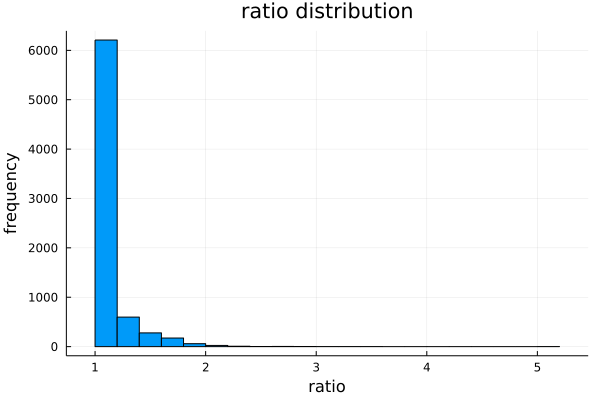

In [ ]:
p = histogram(ratios, label="", bins=20, title="ratio distribution", ylabel="frequency", xlabel="ratio")
savefig("..\\outputs\\Pokemon_image_ratios.png")
p

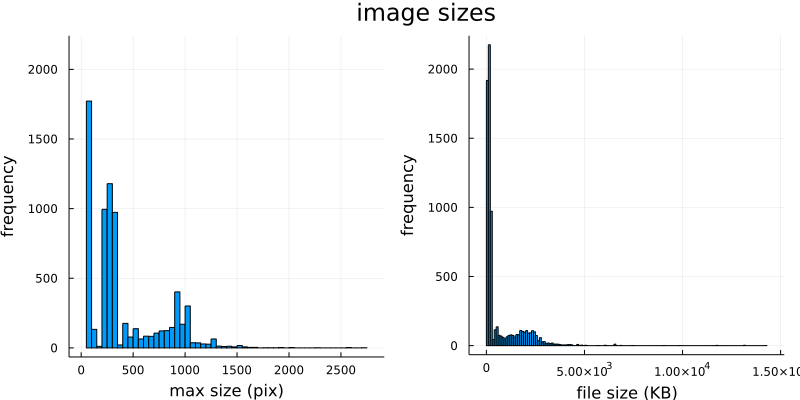

In [ ]:
max_sizes = maximum.(sizes)
h1 = histogram(max_sizes, label="", xlabel="max size (pix)", ylabel="frequency")
h2 = histogram(file_size/1024, label="", xlabel="file size (KB)", ylabel="frequency")
p = plot(h1, h2, plot_title="image sizes", link=:y, size=(800, 400), margin=2Plots.mm)
savefig("..\\outputs\\Pokemon_image_sizes.png")
p

## Preprocessing

In [ ]:
function get_bbox(img, thresh=0.95)
    grey_img = Gray.(img)
    left = size(img, 2)
    right = 1
    top = size(img, 1)
    bottom = 1
    for i in 1:size(img, 1)
        for j in 1:size(img, 2)
            if grey_img[i, j] < thresh
                left = min(left, j)
                right = max(right, j)
                top = min(top, i)
                bottom = max(bottom, i)
            end
        end
    end
    @assert (top < bottom) && (left < right)
    (top, bottom, left, right)
end

function make_square(img, top, bottom, left, right)
    width = right - left
    height = bottom - top
    mid_i = top + round(Int, height/2)
    mid_j = left + round(Int, width/2)
    length = round(Int, max(width, height)/2)
    
    top_new = max(1, mid_i - length)
    bottom_new = min(size(img, 1), mid_i + length - 1)
    left_new = max(1, mid_j - length)
    right_new = min(size(img, 2), mid_j + length - 1)
    
    offset_i = 1 - (mid_i - length)
    offset_j = 1 - (mid_j - length)

    img_square = ones(eltype(img), 2 * length, 2 * length)
    img_square[(top_new:bottom_new) .+ offset_i, (left_new:right_new) .+ offset_j] = 
        img[top_new:bottom_new, left_new:right_new]
    img_square
end

make_square (generic function with 1 method)

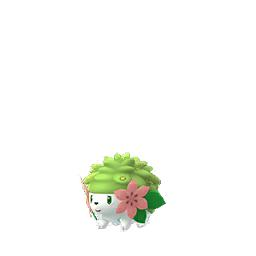

In [ ]:
paths = Dict(
    :shaymin => "Pkmn_img6685.jpg",  # samll with empty space
    :wingull => "Pkmn_img7277.jpg",  # very high aspect ratio (5.1)
    :graveler => "Pkmn_img5145.jpg", # high aspect ratio (1.8)
    :golbat => "Pkmn_img6069.jpg",   # wide but empty space
    :articuno => "Pkmn_img2641.jpg", # large image
    :mega_mewtwo_y => "Pkmn_img21.jpg",   # largest uncompressed image
    :blank => "Pkmn_img2561.jpg"
    )
img = load(joinpath(data_dir_original, paths[:shaymin]))

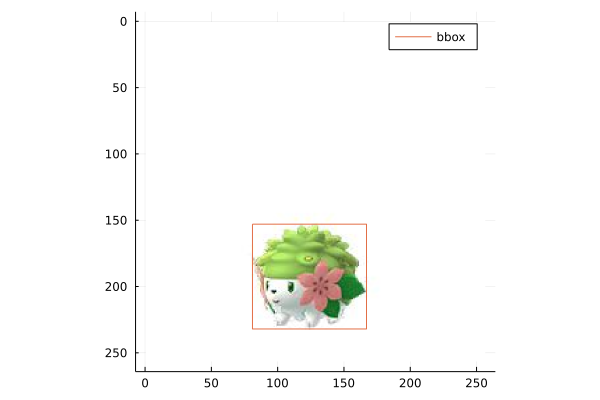

In [ ]:
plot(img)
(top, bottom, left, right) = get_bbox(img)
x, y = [left, right, right, left, left], [top, top, bottom, bottom, top]
plot!(x, y, label="bbox")

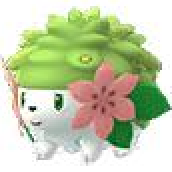

In [ ]:
img_square = make_square(img, top, bottom, left, right)

## Downsample images

In [ ]:
outsize = (48, 48)
outdir = joinpath(data_directory, "$(outsize[1])x$(outsize[2])");
if !isdir(outdir)
    mkdir(outdir)
end
outdir

"C:\\Users\\sinai\\Documents\\Projects\\datasets\\Pokemon\\48x48"

In [ ]:
@showprogress for filename in filenames
    img = load(joinpath(data_dir_original, filename));
    try
        (top, bottom, left, right) = get_bbox(img);
        img_square = make_square(img, top, bottom, left, right)
        img_resized = imresize(img_square, outsize)
        save(joinpath(outdir, filename), img_resized)
    catch e
        println(stderr, "\n$filename: $e")
    end
end

Progress:  34%|███████████████                          |  ETA: 0:00:48
Pkmn_img2561.JPG: AssertionError("top < bottom && left < right")
Progress:  35%|███████████████                          |  ETA: 0:00:48
Pkmn_img2565.JPG: AssertionError("top < bottom && left < right")

Pkmn_img2567.JPG: AssertionError("top < bottom && left < right")
Progress: 100%|█████████████████████████████████████████| Time: 0:02:23


## Convert to Channel View

Flux.Conv requries images in WHCN order (width, height, channels, batch)

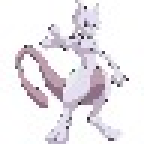

data shape: (48, 48, 3)


In [ ]:
img = load(joinpath(outdir, "Pkmn_img0.jpg"))
display(img)
img_CHW = channelview(img)
img_WHC = permutedims(img_CHW, (3, 2, 1))
data_shape = size(img_WHC)
println("data shape: ", data_shape)

In [ ]:
filenames_downsized = readdir(outdir);
sort!(filenames_downsized, lt=(s1, s2)-> get_pos(s1) < get_pos(s2));

In [ ]:
X = Array{Float32}(undef,  data_shape..., 0)
@showprogress for filename in filenames_downsized
    img = load(joinpath(outdir, filename));
    img_CHW = channelview(img)
    img_WHC = permutedims(img_CHW, (3, 2, 1))
    X = cat(X, img_WHC, dims=4)
end
size(X)

Progress: 100%|█████████████████████████████████████████| Time: 0:17:10


(48, 48, 3, 7356)

In [ ]:
BSON.bson(joinpath(data_directory, "imgs_WHCN_48x48.bson"), Dict(:imgs_WHCN=>X))